## Imports

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits

import multiprocessing
from joblib import parallel_backend, Parallel, delayed
num_cores = multiprocessing.cpu_count()
import glob
from sklearn.model_selection import train_test_split
import random

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../utilities')

import utilities as util
import augmentations as aug

## Model Creation

## U-Net Architecture for Image Segmentation

The U-Net architecture, widely recognized for its efficiency in image segmentation tasks, is characterized by its symmetrical structure. In this notebook, we'll walk through our specific implementation of the U-Net.
Model Parameters

- **Input Shape**: Our binned images come in a grayscale format with dimensions 128x160 (originally 512x640) pixels.
- **Output Channels**: This parameter determines the number of channels in our segmented output. Our current setting outputs a single channel.
- **Channels List**: Represents the number of channels at each encoding layer of our U-Net.

## Building the U-Net Model

The U-Net design is symmetrical with two main components:

- **Encoder** : it contains a series of convolutional layers followed by a maxpooling, the encoder is responsible for capturing the contextual information in the image.
- **Decoder** : Starts by upsampling the image then using the high resolution image from the Encoder as a second input as a skip connection, bridging the gap between the localization and contextual information.
- **Output layer** : a convolutional layer that refines and maps the features to our specified number of output channels.
The activation function 'sigmoid' ensures the output values are between 0 and 1, suitable for image segmentation tasks. to obtain our segmented image




In [12]:
input_shape = (128, 160, 1)
output_channels = 1
channels_list =  [64 , 128 , 256 ]

kernel_initializer='glorot_uniform'

def unet():
    unet_input = tf.keras.layers.Input(shape=input_shape)

    list_features = []
    x = unet_input
    for i, n_channels in enumerate(channels_list):
        x = tf.keras.layers.Conv2D(n_channels, 3, activation='relu', kernel_initializer=kernel_initializer, padding='same', name=f'Encoder_conv_{i}')(x)
        list_features.append((n_channels, x))
        x = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='same')(x)


    for i, (n_channels, same_reso_features) in enumerate(reversed(list_features)):
        x = tf.keras.layers.UpSampling2D(2)(x)
        x = tf.keras.layers.Concatenate(axis=-1)([x, same_reso_features])
        x = tf.keras.layers.Conv2D(n_channels, 3, activation='elu', padding='same', kernel_initializer=kernel_initializer, name=f'Decoder_conv_{i}')(x)


    unet_output = tf.keras.layers.Conv2D(output_channels, 3, activation='sigmoid', padding='same')(x)

    model = tf.keras.Model(unet_input, unet_output, name='unet')

    return model

## Preprocessing

### Data Loading and Preprocessing

For this image segmentation task, our data consists of FITS (Flexible Image Transport System) files.

### Opening and Preprocessing FITS files

Our `open_fits_with_mask` function performs the following tasks:

**File Opening:** Opens the provided `FITS` file using the `fits.open()` method.\
**Extracting Image and Mask:** The function retrieves the actual image data (cloud) and the corresponding segmentation mask.
Normalization: To bring the pixel values within a standard range, the cloud data is normalized using a given DR value.

In [6]:
DR = 2**14
def open_fits_with_mask(filename):
    image = fits.open(filename)
    cloud = image[0].data
    mask = image[1].data
    del image

    # Normalize image
    cloud  = cloud / DR
    return cloud , mask

### Loading the Dataset

**Retrieve File Paths:** We obtain a list of all FITS files present in our specified directory.\
**Shuffle the List:** To ensure randomness and avoid any inherent order bias, we shuffle our list of images.\
**Parallel Processing:** Leveraging the joblib library, we employ parallel processing to efficiently load all our FITS files using multiple cores.

In [7]:
images_list = glob.glob('/gdrive/MyDrive/Colab/CIRRUS/CIRRUS_DS/Seg/DS1_MASKED_SUBSET/*.fits')
images_list = random.choices(images_list, k=len(images_list))

with parallel_backend('threading', n_jobs=num_cores):
    l_fits = Parallel(verbose=0)(delayed(open_fits_with_mask)(filename=r) for r in images_list)
l_fits = np.array(l_fits)

### Quick Visual Inspection

To verify our data loading process and get a sense of our data, we randomly select three images from our dataset.
Display them using the util.plot_image function.

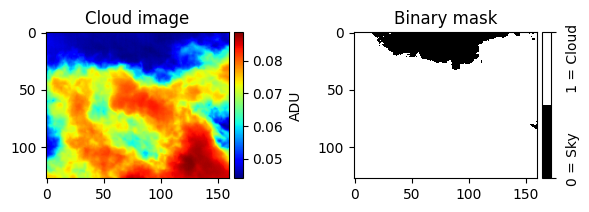

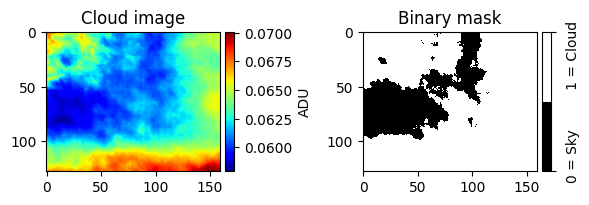

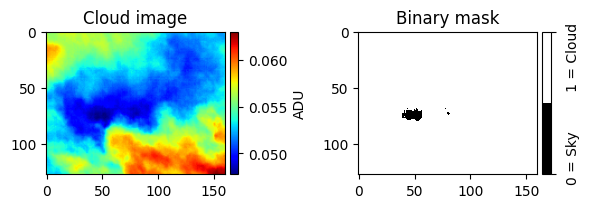

In [11]:
# Collect 3 random tuples from l_fits
random_data = [l_fits[random.randint(0, len(l_fits) - 1)] for _ in range(3)]
# Now use plot_images function to plot these images
viz.plot_images(data_list=random_data, figsize_per_row=(6, 3))

## Data set gen and batching

Training a neural network requires input data in batches. The custom data generator, CloudImageDataGenerator, ensures smooth data flow during training by dividing the dataset into batches and feeding it into the model. This is particularly important when the dataset is too large to fit into memory.

### Data Augmentation on the fly

the data set generator is used to train on batches of images\
Each set of batch is augmented by a parameter `aug_batch_size`


In [8]:
class CloudImageDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, x_data, y_data, batch_size=8,aug_batch_size=2, shuffle=True):
        self.x_data = x_data
        self.y_data = y_data
        self.batch_size = batch_size
        self.aug_batch_size = aug_batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.x_data))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        return int(np.ceil(len(self.x_data) / self.batch_size))

    def __getitem__(self, index):
        start_idx = index * self.batch_size
        end_idx = (index + 1) * self.batch_size
        batch_indices = self.indices[start_idx:end_idx]

        batch_x = self.x_data[batch_indices]
        batch_y = self.y_data[batch_indices]
        # Create a list of tuples using zip
        batch_list = list(zip(batch_x, batch_y))

        if self.aug_batch_size != 0:
            l_fits_aug = [aug.random_augment(img_mask=random.choice(batch_list)) for _ in range(self.aug_batch_size)]
            fits_images_aug = np.array(l_fits_aug)

            batch_x =  np.concatenate((batch_x, fits_images_aug[:,0]), axis=0)
            batch_y =  np.concatenate((batch_y, fits_images_aug[:,1]), axis=0)

        return batch_x, batch_y


    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

Split the data set into training and validation

In [9]:
X_train, X_test, y_train, y_test = train_test_split(l_fits[:,0], l_fits[:,1], test_size=0.2, random_state=42)

## Load the dataset generator
We choose not to augment the validation set because it does not make sense
using a A100 GPU we can load 128 images per batch + 64 augmentation images

This fills 38G out of the available 40G of the VRAM

In [21]:
ds_train_gen = CloudImageDataGenerator(x_data=X_train,y_data=y_train,batch_size=128,aug_batch_size=64, shuffle=True)
ds_val_gen = CloudImageDataGenerator(x_data=X_test,y_data=y_test,batch_size=64,aug_batch_size=0, shuffle=False)

# Model Training and Optimization

Here's a concise overview of the model training setup and results:

**Callbacks:**

- Early Stopping: Monitors the validation loss, halting training if there isn't a significant improvement (<0.01) for 10
- Learning Rate Scheduler: Reduces the learning rate by half every 10 epochs, starting from an initial rate of 0.001.
- Optimizer and Loss: Uses the Adam optimizer with a learning rate of 0.001 and the BinaryCrossentropy loss function.
- Model Compilation and Training: The U-Net model is compiled with the mentionned optimizer and loss, and then trained on the dataset.

In [25]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, min_delta=0.01, mode='auto', baseline=None, restore_best_weights=True)
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.001 * 0.5 ** (epoch // 10) , verbose=1)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.BinaryCrossentropy()

model = unet()
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

history = model.fit(ds_train_gen,validation_data=ds_val_gen, epochs=100, callbacks=[lr_schedule , early_stopping])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/100
19/19 [==============================] - 9s 340ms/step - loss: 0.4395 - accuracy: 0.8242 - val_loss: 0.3979 - val_accuracy: 0.8504 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/100
19/19 [==============================] - 7s 342ms/step - loss: 0.3943 - accuracy: 0.8314 - val_loss: 0.3837 - val_accuracy: 0.8504 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/100
19/19 [==============================] - 6s 329ms/step - loss: 0.3757 - accuracy: 0.8326 - val_loss: 0.3782 - val_accuracy: 0.8504 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/100
19/19 [==============================] - 7s 335ms/step - loss: 0.3705 - accuracy: 0.8322 - val_loss: 0.3774 - val_accuracy: 0.8504 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/100
19/19 [==============================] - 7s 

# Training Result
    
The training process halted after 20 epochs due to our early stopping criteria.
It commenced with a loss of 0.4 and concluded at 0.32, showcasing a modest improvement.

For computational performance, each epoch took approximately 7 seconds on an A100 GPU, with the exception of the first epoch, which required 36 seconds, likely due to initialization overheads.

Utilizing an A100 GPU significantly boosts training speeds, ensuring efficient and swift model optimization.

Thanks to its 40GB of memory, we can load 128 (128x160) images + 64 augmentation per batch.

# Analyzing Training Curves

By plotting the history curves for both loss and accuracy against the training epochs, we ensure that our model's performance on the training data is in harmony with its performance on the validation data. This alignment is crucial to confirm that there's no overfitting, ensuring that our model can generalize well to unseen data.

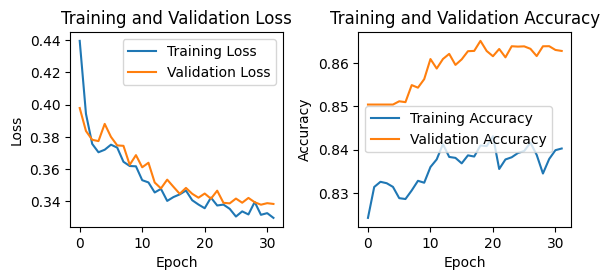

In [26]:
# Plotting
plt.figure(figsize=(6, 5))

# Loss
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Accuracy
plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [36]:
model.save('keras_64_256_full_model.h5')

# Batchwise Predictions and Visualization

Finally, we use the model to make predictions on the test data in a batchwise manner and visualizing the results.

In [27]:
batch_size = 5  # Set the batch size that works for your memory capacity

# Calculate the number of batches
num_batches = len(X_test) // batch_size

# Initialize an empty list to store predictions
all_predictions = []

# Predict using batches
for batch_index in range(num_batches):
    start_index = batch_index * batch_size
    end_index = (batch_index + 1) * batch_size

    batch_X = X_test[start_index:end_index]
    batch_predictions = model.predict(batch_X,verbose=0)
    all_predictions.append(batch_predictions)

# If there are any remaining samples not covered by full batches
if len(X_test) % batch_size != 0:
    last_batch_X = X_test[num_batches * batch_size:]
    last_batch_predictions = model.predict(last_batch_X,verbose=0)

    all_predictions.append(last_batch_predictions)

# Combine predictions from all batches
predictions = np.vstack(all_predictions)  # Assuming numpy is imported
y_predictions = np.squeeze(predictions, axis=-1)

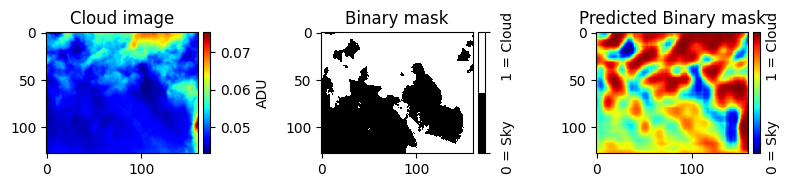

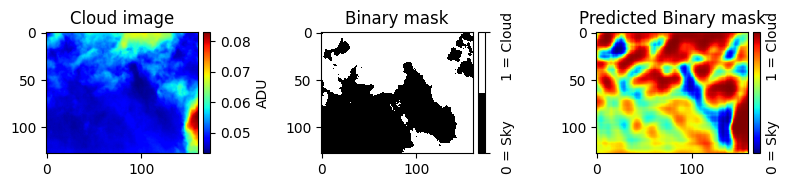

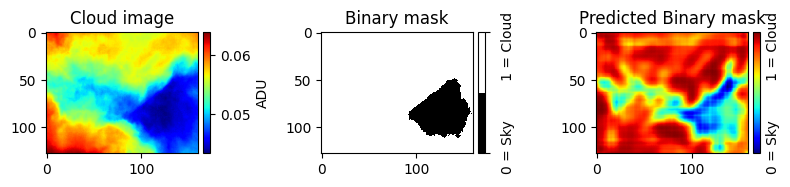

In [35]:
for _ in range(3):
    random_index = random.randint(0, len(X_test) - 1)
    util.plot_image_pred(X_test[random_index],
                         y_test[random_index],
                         y_predictions[random_index],
                         figsize=(8,4),
                         predmask_cmap='jet')

Mean Accuracy: 0.8633
Mean Precision: 0.8745
Mean Recall: 0.9798
BinaryCrossEntropy Loss: 0.3417
IOU: 0.8590


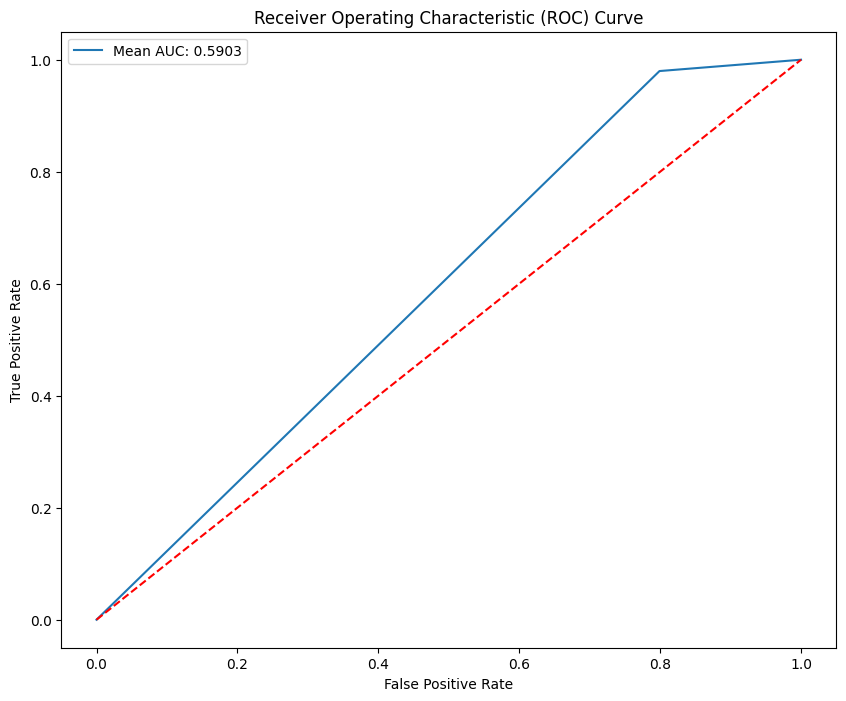

In [34]:
util.evaluate_model(y_test,y_predictions)